 # Recommend three strains based on strain, effects, and flavors proposed by app user.
 
   Documents: are constructed by string representations of **Strain**, **Effects**, and **Flavors**. 
   
   - A Spacy instance is used to create a search space by vectorizing the docs.
   - The docs are vectorized.
   - A function is defined to take a text, searches the space, and returns three closest matches.


In [24]:
# Classics
import pandas as pd
import numpy as np 

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# NLP Libraries
import spacy
from spacy.tokenizer import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer

# Pipeline
from sklearn.neighbors import NearestNeighbors


nlp = spacy.load("en_core_web_md")

In [3]:
df = pd.read_csv('/Users/jorge/Med-Cabinet-2/Data/cannabis.csv')
print(df.shape)
df.head(3)

(2351, 6)


,Strain,Type,Rating,Effects,Flavor,Description
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",$100 OG is a 50/50 hybrid strain that packs a ...
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",The ‘98 Aloha White Widow is an especially pot...
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1024 is a sativa-dominant hybrid bred in Spain...


# Limit search and results to quality strains.
# replace blank flavor with ""
good_stuff = df.replace(np.nan, '', regex=True)

In [4]:
good_stuff = df[df['Rating'] >= 4.0]
good_stuff.shape

(2162, 6)

## Replace Not a Number values to avoid errors.

In [5]:
# replace blank flavor with ""
good_stuff = df.replace(np.nan, '', regex=True)

## A function to standardize our string input:

In [6]:
def clean_string(strng):
    s = strng.replace(","," ") # comma-> space
    s = s.replace("("," ") # (-> space
    s = s.replace(")"," ") # (-> space
    s = s.lower()
    return s

## Combine labels into one string, for vectorization.

In [7]:
# cols = good_stuff.columns
cols = ['Type', 'Effects', 'Flavor', 'Description']

for col in cols:
    good_stuff[col] = good_stuff[col].apply(clean_string)

good_stuff['text'] = good_stuff['Type'] + " " + good_stuff['Effects'] + " " + good_stuff['Flavor']

## Build a list of docs to use fitting model.

In [11]:
def gather_docs(df):
    """ Produces List of Documents from a dataframe.
    
    df: a Pandas dataframe that has the column 'text'.
    
    Returns a list of strings. 
    """
    
    docs = list(df['text'])
    
    return docs

In [12]:
docs = gather_docs(good_stuff)
docs[:5]

['hybrid creative energetic tingly euphoric relaxed earthy sweet citrus',
 'hybrid relaxed aroused creative happy energetic flowery violet diesel',
 'sativa uplifted happy relaxed energetic creative spicy/herbal sage woody',
 'hybrid tingly creative hungry relaxed uplifted apricot citrus grapefruit',
 'hybrid happy relaxed euphoric uplifted talkative citrus earthy orange']

## Instantiate Vectorizer.

In [14]:
vect = CountVectorizer(stop_words='english', max_features=1000)

## Fit Vectorizer to Docs.

In [16]:
vect.fit(docs)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

## Make a Document-Term Matrix, and Densify.

In [18]:
#Create a sparse document-term matrix
dtm = vect.transform(docs)

# Make a dataframe of a condensed version of the DTM, using feature names
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm.head()

,ammonia,apple,apricot,aroused,berry,blue,blueberry,butter,cheese,chemical,...,tar,tea,tingly,tobacco,tree,tropical,uplifted,vanilla,violet,woody
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [19]:
doc_len = [len(doc) for doc in docs]

## Make histogram of occurrence of words in docs.

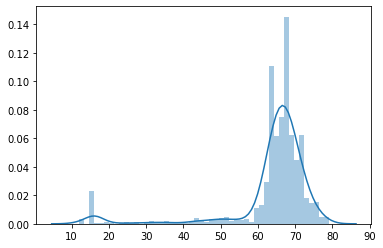

In [23]:
sns.distplot(doc_len)
plt.show()

## Instandiate and fit a nearest neighbors learner.

In [31]:
# Fit on DTM
n = NearestNeighbors(n_neighbors=3, algorithm='ball_tree')
n.fit(dtm)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=3, p=2, radius=1.0)

In [33]:
# Inspect
n.kneighbors([dtm.iloc[0].values])

(array([[0., 2., 2.]]), array([[ 0, 91, 81]]))

In [35]:
# Inspect Most relevant result
docs[0]

'hybrid creative energetic tingly euphoric relaxed earthy sweet citrus'

## Define function to use in retrieving three nearest.

In [36]:
def text_to_top_three(txt):
    """ Receives a string containing strain, effects, and flavors, and 
    
    returns a 2-tuple of (array of scores, array of indexes) describing
    
    the best matches among strains modeled."""
    
    clean_text = clean_string(txt)
    transformed_text = vect.transform(clean_text)
    return nn.kneighbors(transformed_text.todense())